In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re # smi 파일에서 텍스트 뽑아내는 모듈
import pandas as pd
import nltk
nltk.download('punkt')
from nltk import sent_tokenize


def smi_to_df (file_path):
    file = open(file_path, 'r', encoding = 'cp949')
    # 모든 대문자를 소문자로 변환
    wholefile = file.read().lower()
    # 타임스템프와 본문 분리
    pattern = re.compile(r'<sync start=(\d+)><p class=krcc>\n(.*?)\n', re.DOTALL)

    matches = pattern.findall(''.join(wholefile))

    df = pd.DataFrame(matches, columns=['Time_Stamp(s)', 'Text'])
    df['Time_Stamp(s)'] = df['Time_Stamp(s)'].apply(lambda x: float(x)/1000)

    # Text를 하나의 문장으로 합치기
    text = ''.join(df['Text'].tolist())
    sentences = sent_tokenize(''.join(text))
    nltk_df = pd.DataFrame(sentences, columns=['Text'])

    return df, nltk_df, sentences



from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 반말 존댓말 분류 모델
model = AutoModelForSequenceClassification.from_pretrained("j5ng/kcbert-formal-classifier")
tokenizer = AutoTokenizer.from_pretrained('j5ng/kcbert-formal-classifier')

formal_classifier = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

# 의도 파악 모델
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TextClassificationPipeline
# Load fine-tuned model by HuggingFace Model Hub
HUGGINGFACE_MODEL_PATH = "bespin-global/klue-roberta-small-3i4k-intent-classification"
loaded_tokenizer = RobertaTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH )
loaded_model = RobertaForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH )

# using Pipeline
text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    return_all_scores=True
)



def jondatmal_susahak(file_path):

    df, nltk_df, sentences = smi_to_df(file_path)
    fragment, statement, question, command, rhetorical_question, rhetorical_command, intonation_dependent_utterance = 0, 0, 0, 0, 0, 0, 0

    sentences_list = formal_classifier(sentences)
    formal_df = pd.DataFrame(sentences_list)
    # LABEL_0을 반말, LABEL_1을 존댓말로 바꾸기
    formal_df['label'] = formal_df['label'].replace('LABEL_0', '반말')
    formal_df['label'] = formal_df['label'].replace('LABEL_1', '존댓말')

    for i in range(len(sentences)):
        preds_list = text_classifier(sentences[i])
        best_pred = preds_list[0]
        nltk_df.loc[i, '의도'] = max(preds_list[0], key=lambda x: x['score'])['label']
        nltk_df.loc[i, '의도_점수'] = max(preds_list[0], key=lambda x: x['score'])['score']
        if nltk_df.loc[i, '의도'] == 'fragment':
            fragment += 1
        elif nltk_df.loc[i, '의도'] == 'statement':
            statement += 1
        elif nltk_df.loc[i, '의도'] == 'question':
            question += 1
        elif nltk_df.loc[i, '의도'] == 'command':
            command += 1
        elif nltk_df.loc[i, '의도'] == 'rhetorical_question':
            rhetorical_question += 1
        elif nltk_df.loc[i, '의도'] == 'rhetorical_command':
            rhetorical_command += 1
        elif nltk_df.loc[i, '의도'] == 'intonation_dependent_utterance':
            intonation_dependent_utterance += 1

    df_concat = pd.concat([nltk_df,formal_df], axis=1)
    df_concat.columns=['문장', '의도','의도_점수', 'label', 'score']

    df_result = df_concat.groupby(['의도','label'])['score'].count().unstack(fill_value=0).stack()

    df_result = pd.DataFrame(df_result).reset_index()
    df_rds = df_result.copy()

    new_column = df_result['의도'] + '_' + df_result['label']
    df_rds.insert(loc=2, column='reset', value=new_column)
    df_rds = df_rds.drop(['의도','label'], axis=1)
    # re를 행렬 변환
    df_rds = df_rds.T
    # column 행을 행이름으로 지정
    df_rds.columns = df_rds.iloc[0]
    df_rds.drop(df_rds.index[0], inplace=True)
    df_rds = df_rds.rename_axis(columns=None).reset_index(drop=True)


    return df_rds

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/250k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/272M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
df

,command_반말,command_존댓말,fragment_반말,fragment_존댓말,intonation-dependent utterance_반말,intonation-dependent utterance_존댓말,question_반말,question_존댓말,rhetorical question_반말,rhetorical question_존댓말,statement_반말,statement_존댓말
0,5,14,1,1,1,1,30,42,7,25,52,325


In [ ]:
list_append = []
list_append.append(['수학', '확통']+df.iloc[0].values.tolist())

In [ ]:
list_append

[['수학', '확통', 5, 14, 1, 1, 1, 1, 30, 42, 7, 25, 52, 325]]

In [ ]:
def get_smi_file_names(path):
    smi_file_names = []
    for file in os.listdir(path):
        if file.endswith(".smi") and os.path.isfile(os.path.join(path, file)):
            smi_file_names.append(file)
    return smi_file_names

In [ ]:
pwd

'/content'

In [ ]:
import os

class_path ='/content/drive/MyDrive/인강프로젝트/EBS 스크립트 데이터/인기 강사/정승제'
class_names = os.listdir(class_path)
list_append = []
for folder_name in class_names:
  T_name = class_path.split('/')[-1]
  class_name = folder_name
  smi_file_path = class_path+ '/' +folder_name
  smi_files = get_smi_file_names(smi_file_path)


  for file_name in smi_files:
      try:
        df = jondatmal_susahak(smi_file_path +'/'+ file_name)
        print(T_name)
        print(file_name)

        list_append.append(['수학','확통',T_name, class_name, file_name] + df.iloc[0].values.tolist())
      except Exception as e:
        print("********************")
        print(file_name)
        print(e)
        print("********************")
        pass
df = pd.DataFrame(list_append, columns = ['과목','세부과목','선생님이름','강좌명','강의명','command_반말','command_존댓말','fragment_반말', 'fragment_존댓말', 'intonation-dependent utterance_반말', 'intonation-dependent utterance_존댓말', 'question_반말', 'question_존댓말', 'rhetorical question_반말', 'rhetorical question_존댓말','statement_반말', 'statement_존댓말' ])
# 데이터프레임을 CSV 파일로 저장
csv_file_path = f"/content/drive/MyDrive/인강프로젝트/분석결과/수사학and존댓말/{T_name}.csv"
df.to_csv(csv_file_path, index=False, encoding="utf-8")

정승제
01강 합의 법칙, 곱의 법칙_(고3-기본).smi
정승제
02강 순열의 뜻, 순열 Top 5 (1)_(고3-기본).smi
정승제
03강 순열 TOP5(2), 조합의 뜻_(고3-기본).smi
정승제
04강 조합 TOP4, 원순열의 뜻_(고3-기본).smi
정승제
05강 원순열(2), 중복순열(1)_(고3-기본).smi
정승제
06강 중복순열(2), 같은 것이 있는 순열(1)_(고3-기본).smi
정승제
07강 같은 것이 있는 순열(2)_(고3-기본).smi
정승제
09강 여러 가지 순열 연습 문제(2)_(고3-기본).smi
정승제
08강 여러 가지 순열 연습 문제(1)_(고3-기본).smi
정승제
10강 여러 가지 순열 연습 문제(3)_(고3-기본).smi
정승제
11강 여러 가지 순열 연습 문제(4)_(고3-기본).smi
정승제
13강 복잡한 부정방정식의 해의 개수_(고3-기본).smi
정승제
12강 여러 가지 순열 연습 문제(5), 중복조합, 부정방정식의 해의 개수_(고3-기본).smi
정승제
14강 이항정리(1)_(고3-기본).smi
정승제
15강 이항정리(2)_(고3-기본).smi
정승제
16강 이항계수의 성질_(고3-기본).smi
정승제
17강 중복조합과 이항정리 연습문제(1)_(고3-기본).smi
정승제
18ᄀ

ValueError: ignored

In [ ]:
df = pd.DataFrame(list_append, columns = ['과목','세부과목','선생님이름','강좌명','강의명','command_반말','command_존댓말','fragment_반말', 'fragment_존댓말', 'intonation-dependent utterance_반말', 'intonation-dependent utterance_존댓말', 'question_반말', 'question_존댓말', 'rhetorical command_반말', 'rhetorical command_존댓말', 'rhetorical question_반말', 'rhetorical question_존댓말','statement_반말', 'statement_존댓말' ])

In [ ]:
list_append

[['수학', 11, 35, 8, 0, 1, 0, 68, 59, 1, 0, 25, 53, 37, 173]]

In [ ]:
list_append

[]

## 시각화

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

def jondatmal_susahak_visualization(file_path):
    df_rds = jondatmal_susahak(file_path)

    list = []
    # 데이터 이동
    for category in df_rds.columns.str.split('_').str[0].unique():
        row = {
            '의도': category,
            '반말': df_rds[f'{category}_반말'].values[0],
            '존댓말': df_rds[f'{category}_존댓말'].values[0]
        }
        list.append(row)
    result_df_test = pd.DataFrame(list)


    # Calculate the ratio of 반말 and 존댓말 for each intent
    result_df_test['반말_비율'] = result_df_test['반말'] / (result_df_test['반말'] + result_df_test['존댓말'])
    result_df_test['존댓말_비율'] = result_df_test['존댓말'] / (result_df_test['반말'] + result_df_test['존댓말'])

    type_mapping = {'statement': '설명',
                'question': '질문',
                'command': '지시어',
                'rhetorical question': '수사학적 질문',
                'fragment': '불완전 문장',
                'rhetorical command': '수사학적 명령'}

    result_df_test['의도'] = result_df_test['의도'].map(type_mapping)
    result_df_test.dropna(inplace=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot only 반말 and 존댓말
    result_df_test[['반말', '존댓말']].plot(kind='bar', stacked=True, ax=ax)

    # Adding labels and title
    plt.xlabel('의도')
    plt.ylabel('Score')
    plt.title('Score Distribution by Intent and Politeness Level')

    total_bars = result_df_test["반말"].sum() + result_df_test["존댓말"].sum()

    # Display ratio text at the top of the graph
    for idx, (bm, jm, total) in enumerate(zip(result_df_test['반말_비율'], result_df_test['존댓말_비율'], result_df_test['반말'] + result_df_test['존댓말'])):
        ratio_text = f'반말 : {bm:.1%} \n 존댓말 :  {jm:.1%}\n'
        ax.annotate(f'문장 비율 : {round(total / total_bars*100,2)}% \n {ratio_text}', (idx, total), ha='center', va='bottom', fontsize=8)

    # Set x-axis labels
    ax.set_xticks(range(len(result_df_test)))
    ax.set_xticklabels(result_df_test['의도'], rotation=45, ha='right')  # You can adjust rotation and ha as needed

    # Set y-axis limit
    max_total = result_df_test[['반말', '존댓말']].sum(axis=1).max() * 1.2
    ax.set_ylim(0, max_total)

    # Modify legend labels and order, adjust layout
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='', bbox_to_anchor=(1, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()
    return plt.show()

C:\Users\big-03-06\AppData\Local\Temp\ipykernel_20056\1197712147.py:67: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'statement' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  nltk_df.loc[i, '의도'] = max(preds_list[0], key=lambda x: x['score'])['label']


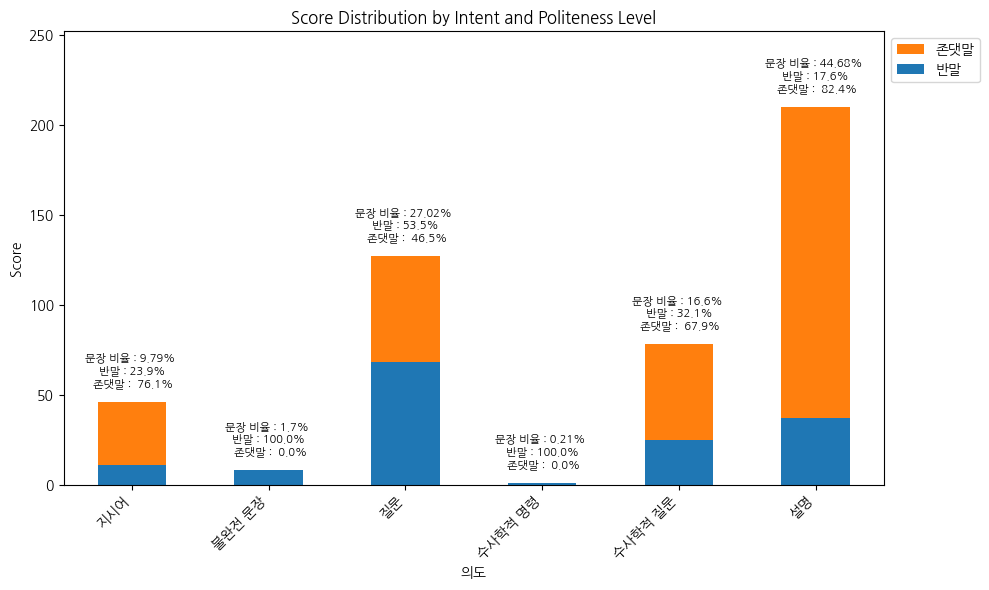

In [ ]:
jondatmal_susahak_visualization("./2강. 순열과 조합(2)_(고2-기본).smi")